In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Hyperparameters
vocab_size = 1000 # was 10,000
embedding_dim = 16
max_length = 120 # was 32
trunc_type = 'post'
oov_tok = "<OOV>"
training_size = 20000
padding_type="post"

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

with open("/tmp/sarcasm.json", 'r') as f:
  datastore = json.load(f)

--2021-01-27 00:07:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-01-27 00:07:55 (100 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
sentences = []
labels = []

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])

In [5]:
len(sentences)

26709

In [6]:
training_sentences = sentences[0: training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

In [8]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(24, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 16)            16000     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(training_padded, training_labels, epochs=30,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 1s - loss: 0.5237 - accuracy: 0.7362 - val_loss: 0.4085 - val_accuracy: 0.8120
Epoch 2/30
625/625 - 1s - loss: 0.3773 - accuracy: 0.8285 - val_loss: 0.4061 - val_accuracy: 0.8144
Epoch 3/30
625/625 - 1s - loss: 0.3627 - accuracy: 0.8329 - val_loss: 0.4137 - val_accuracy: 0.8058
Epoch 4/30
625/625 - 1s - loss: 0.3581 - accuracy: 0.8379 - val_loss: 0.4018 - val_accuracy: 0.8152
Epoch 5/30
625/625 - 1s - loss: 0.3555 - accuracy: 0.8390 - val_loss: 0.4052 - val_accuracy: 0.8143
Epoch 6/30
625/625 - 1s - loss: 0.3529 - accuracy: 0.8403 - val_loss: 0.4072 - val_accuracy: 0.8070
Epoch 7/30
625/625 - 1s - loss: 0.3521 - accuracy: 0.8403 - val_loss: 0.4049 - val_accuracy: 0.8134
Epoch 8/30
625/625 - 1s - loss: 0.3506 - accuracy: 0.8411 - val_loss: 0.4083 - val_accuracy: 0.8074
Epoch 9/30
625/625 - 1s - loss: 0.3498 - accuracy: 0.8393 - val_loss: 0.4090 - val_accuracy: 0.8128
Epoch 10/30
625/625 - 1s - loss: 0.3474 - accuracy: 0.8425 - val_loss: 0.4028 - val_accuracy: 0.8138

In [10]:
import matplotlib.pyplot as plt 

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

#plot_graphs(history, "accuracy")
#plot_graphs(history, "loss")

#Single LSTM

In [11]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(24, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(training_padded, training_labels, epochs=50,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50
625/625 - 17s - loss: 0.4696 - accuracy: 0.7692 - val_loss: 0.3969 - val_accuracy: 0.8182
Epoch 2/50
625/625 - 8s - loss: 0.3665 - accuracy: 0.8339 - val_loss: 0.3889 - val_accuracy: 0.8252
Epoch 3/50
625/625 - 8s - loss: 0.3486 - accuracy: 0.8424 - val_loss: 0.3855 - val_accuracy: 0.8264
Epoch 4/50
625/625 - 8s - loss: 0.3323 - accuracy: 0.8515 - val_loss: 0.3735 - val_accuracy: 0.8280
Epoch 5/50
625/625 - 8s - loss: 0.3179 - accuracy: 0.8574 - val_loss: 0.3710 - val_accuracy: 0.8305
Epoch 6/50
625/625 - 7s - loss: 0.3066 - accuracy: 0.8633 - val_loss: 0.3777 - val_accuracy: 0.8280
Epoch 7/50
625/625 - 8s - loss: 0.3002 - accuracy: 0.8687 - val_loss: 0.3867 - val_accuracy: 0.8229
Epoch 8/50
625/625 - 8s - loss: 0.2948 - accuracy: 0.8695 - val_loss: 0.3855 - val_accuracy: 0.8272
Epoch 9/50
625/625 - 7s - loss: 0.2904 - accuracy: 0.8719 - val_loss: 0.3830 - val_accuracy: 0.8275
Epoch 10/50
625/625 - 8s - loss: 0.2841 - accuracy: 0.8772 - val_loss: 0.3862 - val_accuracy: 0.831

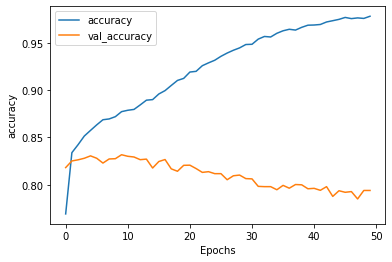

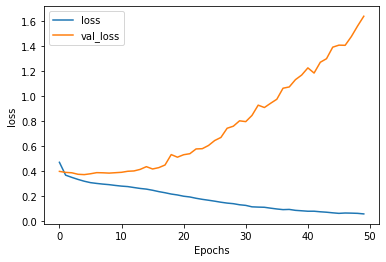

In [13]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

#Convolutional

In [14]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
     tf.keras.layers.Conv1D(128, 5, activation='relu'),
     tf.keras.layers.GlobalMaxPooling1D(),
     tf.keras.layers.Dense(24, activation='relu'),
     tf.keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(training_padded, training_labels, epochs=50,
                    validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/50
625/625 - 3s - loss: 0.4753 - accuracy: 0.7606 - val_loss: 0.4019 - val_accuracy: 0.8174
Epoch 2/50
625/625 - 2s - loss: 0.3562 - accuracy: 0.8418 - val_loss: 0.3902 - val_accuracy: 0.8192
Epoch 3/50
625/625 - 2s - loss: 0.3158 - accuracy: 0.8606 - val_loss: 0.3972 - val_accuracy: 0.8210
Epoch 4/50
625/625 - 2s - loss: 0.2799 - accuracy: 0.8821 - val_loss: 0.4186 - val_accuracy: 0.8173
Epoch 5/50
625/625 - 2s - loss: 0.2473 - accuracy: 0.8952 - val_loss: 0.4469 - val_accuracy: 0.8131
Epoch 6/50
625/625 - 2s - loss: 0.2137 - accuracy: 0.9136 - val_loss: 0.4678 - val_accuracy: 0.8126
Epoch 7/50
625/625 - 2s - loss: 0.1830 - accuracy: 0.9284 - val_loss: 0.5336 - val_accuracy: 0.8041
Epoch 8/50
625/625 - 2s - loss: 0.1575 - accuracy: 0.9380 - val_loss: 0.5759 - val_accuracy: 0.8001
Epoch 9/50
625/625 - 2s - loss: 0.1303 - accuracy: 0.9517 - val_loss: 0.6286 - val_accuracy: 0.8041
Epoch 10/50
625/625 - 2s - loss: 0.1104 - accuracy: 0.9602 - val_loss: 0.7150 - val_accuracy: 0.7988

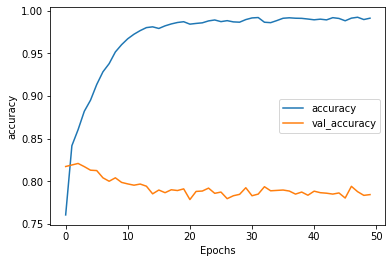

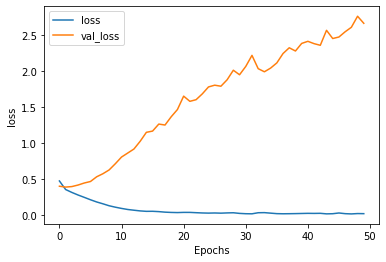

In [16]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")